### Diplom thesis
- vyzkouset/najit spravnou **architekturu neuronove site** (LSTM 2-3 vnitrni vrstvy, droup out vyzkouset, zmensovani velikosti vrstev, hyperopt, pouzit Keras?)
- **optimalizace parametru** neuronove site
- provest **uceni neuronove site** (to mozna nechat na konec, provest 20x-30x beh nebo cross validaci -> zprumerovat? at je to pouzitelne ono to vychazi dost ruzne)

In [120]:
# keras module for building LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
from keras import models 
# from tensorflow.keras.layers import Input, Embedding, LSTM, 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
import string, os 
import math
from matplotlib import pyplot as plt

import ast
from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools

import re
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from hyperopt.pyll.base import scope 
from hyperopt import pyll, hp, Trials, fmin, tpe, STATUS_OK
# from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor 
# import scikeras
# from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle

# Load data

# Trenovani neuronove site

In [121]:
def showPlot(history,linearNotation_name,modelLossPlot_name):
    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - '+linearNotation_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(modelLossPlot_name)
    plt.show()

### Pomocne funkce

In [122]:
# kontrola, rozdeleni data tak je vzdy stejne i kdyz pouziji data pro jiny chem. lin. zapis
def splitData(idx, list_token, ys, RANDOM_STATE):  
    # smiles ulozeni tokenu pro smiles
    X_train, X_test, y_train, y_test = train_test_split(list_token, ys, test_size=0.2,shuffle=True, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=True, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2
    t_w= len(np.unique(list(itertools.chain.from_iterable(X_train))))
    
    return X_train,y_train,X_val,y_val,X_test,y_test,t_w

In [123]:
# vytvoreni modelu s tunnenim parametru
def create_model(units, layers, rate, max_length, vocab_size):
    n_features = 1
    # tady je treba to nastavit podle nejvyssiho indexu, jinak embedding vyhodi chybu
    vocab_size=vocab_size+10000
    # Keras LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))

    if layers == 1:
        model.add(LSTM(units=units, input_shape=(max_length, n_features) ))
        model.add(Dropout(rate=rate))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=units, return_sequences=True, input_shape=(max_length, n_features)))
        model.add(Dropout(rate=rate))

        # Middle layers return sequences
        for i in range(layers-2):
            model.add(LSTM(units=units, return_sequences=True))
            model.add(Dropout(rate=rate))

        # Last layer doesn't return anything
        model.add(LSTM(units=units))
        model.add(Dropout(rate=rate))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse'])
    return model

In [124]:
# objective funkce pro hyperopt s cross validaci
def objective(params, list_token, n_patience, idx, max_length,vocab_size, n_folds=2):
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=n_patience)
    # mc = ModelCheckpoint(bestModel_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    # result = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, verbose=0, callbacks=[es, mc])
    
    model_nn = KerasRegressor(build_fn = create_model,**params, max_length=max_length,vocab_size=vocab_size,  epochs = 400, verbose = 0)
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model_nn, X_train, y_train,scoring='neg_mean_squared_error', cv=kfold,fit_params={'callbacks':[es]},error_score='raise').mean()
    loss = -score
    print('params:\t',params)
    print('score:\t',loss)
    
    # Dictionary with information for evaluation
    return {
        'loss': loss,
        'params': params,
        'status': STATUS_OK }

In [125]:
def replaceMultiWhitespaceSingle(x):
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    my_str = _RE_COMBINE_WHITESPACE.sub(" ", x).strip()
    # print(my_str.count('[')-1)
    # print(type(my_str))
    # print(my_str[1:1100])
    # for i in range(my_str.count('[')-1):
    #     print('i = '+str(i))
    #     print(re.findall(r"\[(.+?)\]", x[1:]))
    #     print(re.findall(r"\[(.+?)\]", x[1:])[i])
    
    y = [re.findall(r"\[(.+?)\]", my_str[1:])[i] for i in range(my_str.count('[')-1)]
        # print(y)
        # r'\d+'
    res = [re.findall(r"\d+\.\d+", y[i]) for i in range(len(y))]
    return res

In [126]:
# nacteny list tokenu prevedu na list a pak pomoci pad_sequence na validni vstup do neuronove site
def createListToken(df, RANDOM_STATE, limit, col_names):  
    list_tokens = []
    for col_name in col_names:
        # np.array(x, dtype=np.float)
        res = df[col_name+'_SPE2Vec'].apply(lambda x: replaceMultiWhitespaceSingle(x))
        # print(res[0])
#         x = '''[1482.5, array([-0.09798757, 0.14100067, -0.29476792, -0.35458204, -0.2151826]) , 1482.5]'''
#         x = "[['ATRM', 'SIF', 'NWPX'], ['NAV','SENEA'], ['HES','AGYS', 'CBST', 'GTIM', 'XRSC']]"
        list_tokens.append(res) 
    return list_tokens

In [127]:
# x = '[1482.5, array([-0.09798757, 0.14100067, -0.29476792, -0.35458204, -0.2151826]),array([-0.09798757, 0.14100067, -0.29476792, -0.35458204, -0.2151826]), 1482.5]'
        
# # x = "[['ATRM', 'SIF', 'NWPX'], ['NAV','SENEA'], ['HES','AGYS', 'CBST', 'GTIM', 'XRSC']]"

# y = [re.findall(r"\[(.+?)\]", x[1:])[i] for i in range(x.count('[')-1)]
# print(y)
# r'\d+'
# answer = [re.findall(r"\d+\.\d+", y[i]) for i in range(len(y))]
    
# y = [re.findall(r" array\(\[(.+?)\]\, dtype=float32\)", x[1:])[i] for i in range(x.count('[')-1)]

# answer = [re.findall(r"'(.+?)'", y[i]) for i in range(len(y))]
# print(answer)

# Novy pokus a spravne

In [128]:
# zkontrolovat, jestli se jedna os pravny chemicky linearni zapis

# tokenization_names = ['bpe','atom','char','spe','kmer']
tokenization_names = ['spe']
fileName_tokenization = ['../data/VEGF2_ChEMBL28_tokenizationSPE_oneHotEncoding_listTokensIds_SPE2Vec.csv']
# fileName_tokenization = ['../data/VEGF2_ChEMBL28_tokenizationSPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv']
# linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
linearNotation_names = ['canonical_smiles']
m_e=1
n_patience = 3
RANDOM_STATE=42
limit =20

space = {'rate'              : hp.uniform('rate',0.01,0.5),
         'units'             : scope.int(hp.quniform('units',10,120,5)),
         'layers'            : scope.int(hp.quniform('layers',2,3,1))}

for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    print('\n'+tokenization)
    df = pd.read_csv(fileName_tokenization[i],sep=',')
    
    ys = df['value'][:limit]
    list_token = createListToken(df, RANDOM_STATE, limit, linearNotation_names)
    # list_token = np.array(list_token)
    # list_token = list_token[0]
    # print(list_token.shape)
    # print(len(list_token[0]))
    # print(len(list_token[0][0]))
    # print(len(list_token[0][0][0]))
    # print(len(list_token[0][0][0][0]))
    # print(list_token[0][0][0])
    # # arr = numpy.array(lst)
 
    
    # X = numpy.zeros((6000, 64, 100, 50), dtype=numpy.uint8)
    # X = numpy.reshape(X, (6000, 64, 100*50))
    
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
       
        # # input shape
        # # (batch_size, timesteps, input_dim)
        # # (6000, 64, 100, 50) The 6000 is just the number of sample sequences. Each sequences is 64 in length.
        # # In your case you have 64 timesteps where each step is of shape (100, 50). The easiest way to get the model working is to reshape your data to (100*50).
        # print('   ',chem_notation)
        # model = Sequential()
        # model.add(LSTM(units=30, input_shape=(len(list_token[0]),len(list_token[0][0]),len(list_token[0][0][0]))))
        # model.add(Dropout(rate=0))




spe


In [129]:
# list_token

In [159]:
temp=[i for i in list_token]
temp = temp[0].tolist()
# print(temp)
    # for j in range(len(linearNotation_names)):
    #     chem_notation = linearNotation_names[j]
       
        # input shape
        # (batch_size, timesteps, input_dim)
        # (6000, 64, 100, 50) The 6000 is just the number of sample sequences. Each sequences is 64 in length.
        # In your case you have 64 timesteps where each step is of shape (100, 50). The easiest way to get the model working is to reshape your data to (100*50).
# # to je jeden velky list
# for i in range(len(temp)):
#     # po radcich jak to bylo v dataframu
#     for j in range(len(temp[i])):
#         for k in range(len(temp[i][j])):
#             # temp[i][j][k] = list(map(float, temp[i][j][k]))
#             temp[i][j][k]  = [float(i) for i in temp[i][j][k]]
            
res = [[[float(i) for i in second_dim] for second_dim in one_dim] for one_dim in temp]
print(type(res))   
        

# X = numpy.zeros((6000, 64, 100, 50), dtype=numpy.uint8)
# X = numpy.reshape(X, (6000, 64, 100*50))

# print(arr)
# arr = np.array(arr)[indices.astype(int)]
#                   # radku               # tokenu               # cisel zakorovnaeho tokenu
# np.array(arr).reshape(len(list_token[0]), len(list_token[0][0]), list_token[0][0][0])
# X = numpy.zeros((6000, 64, 100, 50), dtype=numpy.uint8)
# arr = np.reshape(arr, (len(arr), len(arr[0]), len(arr[0][0])))
# print(type(arr))
# print(type(arr[0]))
# # print(arr[0])
# print(type(arr[0][0]))
# arr=np.array(arr)
# print(arr)
# # print(arr[:2])
# # arr.shape


<class 'list'>


In [172]:
from keras.preprocessing import sequence
# print(len(res))
# print(len(res[1]))  
# print(len(res[1][2]))  
# X = numpy.zeros((6000, 64, 100), dtype=numpy.uint8)
length_arr=[]
for l in res:
    length_arr.append(len(l))
len_vector = len(res[0][0])
addPadVector = [0 for i in range(len_vector)]

max_length=25

for i in range(len(res)):
    for j in range(max_length+1):
        if(j > len(res[i])):
            res[i].append(addPadVector)
            
for i in range(len(res)):
    if(len(res[i])>max_length):
        res[i]=res[i][:max_length]
            
print(max_length)
# print(len(res))
# print(len(res[1]))  
# print(len(res[1][2]))         
# print(res[0])
lengths = [len(res[i]) for i in range(len(res))]
# set()
# lengths
# data_array=sequence.pad_sequences(res[0],maxlen=max_length)
# data_array
# arr = np.reshape(arr, (len(arr), len(arr[0]), len(arr[0][0])))
# arr = np.reshape(res, (len(res), len(res[0]), len(res[0][0])))

25


In [174]:
res = np.array(res)

In [183]:

# n_features = 1
# vocab_size=vocab_size+10000
# Keras LSTM model
model = Sequential()
# model.add(Embedding(vocab_size, params['units_embedding'], input_length=max_length))

model.add(LSTM(units=30, return_sequences=True, input_shape=(res.shape[0],res.shape[1])))

# model.add(LSTM(units=params['units1'], return_sequences=True, input_shape=(max_length, n_features)))
# model.add(Dropout(rate=params['rate1']))

# Middle layers return sequences
# for i in range(params['layers']-2):
    # model.add(LSTM(units=params['units2'], return_sequences=True))
    # model.add(Dropout(rate=params['rate2']))

# Last layer doesn't return anything
# model.add(LSTM(units=params['units3']))
# model.add(Dropout(rate=params['rate3']))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam',metrics=['mse'])
# model
model.summary
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
# # train model
# result = m.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, verbose=0, callbacks=[es])
# # model prediction
# y_pred = m.predict(X_test)

# plotPredictReal(y_pred, y_test,tokenization,chem_notation,fileNameEncoding)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f98dc848d00>>

In [184]:
n_batch = len(res)
# n_epoch = 1000
n_neurons = 32
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, res.shape[1], res.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam',metrics=['mse'])
# model
print(model.summary)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
# train model
# model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
result = m.fit(X_train, y_train, batch_size=n_batch, validation_data=(X_val, y_val), epochs=400, verbose=1, callbacks=[es])
# model prediction
y_pred = m.predict(X_test)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f97c633f130>>

(array([  16.,    0.,   82.,    0.,  232.,    0.,    0.,  575.,    0.,
         744.,    0.,    0.,  981.,    0., 1000.,    0.,    0.,  862.,
           0.,  757.,    0.,  706.,    0.,    0.,  513.,    0.,  334.,
           0.,    0.,  189.,    0.,   91.,    0.,    0.,   37.,    0.,
          17.,    0.,    8.,    0.,    0.,    4.,    0.,    3.,    0.,
           0.,    3.,    0.,    2.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 4.        ,  4.41111111,  4.82222222,  5.23333333,  5.64444444,
         6.05555556,  6.46666667,  6.87777778,  7.28888889,  7.7       ,
         8.11111111,  8.52222222,  8.93333333,  9.34444444,  9.75555556,
        10.16666667, 10.57777778, 10.98888889, 11.4       , 11.811111

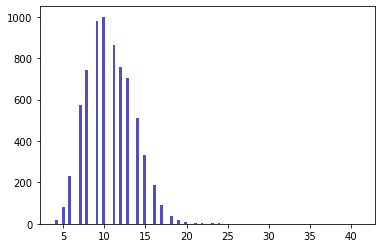

In [155]:
plt.hist(x=length_arr, bins='auto', color='#0504aa', alpha=0.7,rwidth=0.85)

[[[1.   2.2  3.3 ]
  [4.   0.55 6.  ]]

 [[1.1  2.   3.  ]
  [4.5  5.   6.  ]]]
(2, 2, 3)


In [ ]:
     
        n_features = 1
        # tady je treba to nastavit podle nejvyssiho indexu, jinak embedding vyhodi chybu
        vocab_size=t_w+10000
        # Keras LSTM model
        model = Sequential()
#         model.add(Embedding(vocab_size, 100, input_length=max_length))

        # print(X_train.shape)
        # print(X.shape[1])
        # print(X.shape[2])   
    # model.add(LSTM(units=30, input_shape=(X.shape[1], X.shape[2]) ))
        # model.add(Dense(1, activation='linear'))
        # model.compile(loss='mse', optimizer='adam',metrics=['mse'])

#         list_token = list_tokens[j][:limit]
#         max_length=lengths_lst_tokenIdxs[tokenization][j]
#         X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)

#         # zatim mam jen chemicke linearni zapisy
#         fmin_objective = partial(objective,list_token=list_token, n_patience =  n_patience,idx=j,vocab_size = t_w ,max_length = max_length)
        
#         bayes_trials = Trials()

#         best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, max_evals = m_e, trials = bayes_trials)#, rstate = np.random.RandomState(50))

#         best_loss = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['loss']
#         best_params = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['params']
#         print('best params:\t',best_params,'best loss:\t',best_loss,end = '\n')
df.head(1)

In [13]:
from numpy import array
data = array([
    [0.1, 1.0],
    [0.2, 0.9],
    [0.3, 0.8],
    [0.4, 0.7],
    [0.5, 0.6],
    [0.6, 0.5],
    [0.7, 0.4],
    [0.8, 0.3],
    [0.9, 0.2],
    [1.0, 0.1]])
data = data.reshape(1, 10, 2)
print(data.shape)

(1, 10, 2)


In [26]:
# list_token[0]
# print(len(list_token[0]))
# print(list_token[0])
# print(list_token[1])
# print(list_token[2])
print(len(list_token[1]))
print(len(list_token[2]))
# data.reshape(len(list_token[0]), len(list_token[0][1]), n_features)

15416
13953


In [16]:
# nacteny list tokenu prevedu na list a pak pomoci pad_sequence na validni vstup do neuronove site
def createListTokenOut(df, RANDOM_STATE, limit, col_names):  
    list_tokens = []

    for col_name in col_names:
        res = df[col_name+'_tokenIndexList'].apply(lambda x: ast.literal_eval(x))
        vector_with_padding = pad_sequences(res, maxlen=len(res[0]), padding='post', truncating='post')
        list_tokens.append(vector_with_padding) 
    return list_tokens

In [18]:
def builtModelParams(params,max_length,list_token,j, vocab_size):
    n_features = 1
    vocab_size=vocab_size+10000
    # Keras LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, params['units_embedding'], input_length=max_length))

    # if layers == 1:
    #     model.add(LSTM(units=params['units'], input_shape=(max_length, n_features) ))
    #     model.add(Dropout(rate=params['rate']))
    # else:
        # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=params['units1'], return_sequences=True, input_shape=(max_length, n_features)))
    model.add(Dropout(rate=params['rate1']))

    # Middle layers return sequences
    for i in range(params['layers']-2):
        model.add(LSTM(units=params['units2'], return_sequences=True))
        model.add(Dropout(rate=params['rate2']))

    # Last layer doesn't return anything
    model.add(LSTM(units=params['units3']))
    model.add(Dropout(rate=params['rate3']))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse'])
    return model

In [21]:
def showPlot(history,linearNotation_name):
    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - '+linearNotation_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [22]:
def plotPredictReal(predictions,y_test,tokenization,chem_notation):
        plt.figure(figsize=(10,10))
        plt.scatter(y_test, predictions, c='crimson')
        p1 = max(max( predictions), max(y_test))
        p2 = min(min( predictions), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.title(tokenization+' '+chem_notation, fontsize=15)
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show


bpe
Epoch 1/400
135/135 [==============================] - 13s 72ms/step - loss: 7.0120 - mse: 7.0120 - val_loss: 1.1567 - val_mse: 1.1567
Epoch 2/400
135/135 [==============================] - 9s 68ms/step - loss: 1.5806 - mse: 1.5806 - val_loss: 1.1691 - val_mse: 1.1691
Epoch 3/400
135/135 [==============================] - 9s 67ms/step - loss: 1.5687 - mse: 1.5687 - val_loss: 1.1580 - val_mse: 1.1580
Epoch 4/400
135/135 [==============================] - 9s 68ms/step - loss: 1.5588 - mse: 1.5588 - val_loss: 1.1556 - val_mse: 1.1556
Epoch 5/400
135/135 [==============================] - 9s 68ms/step - loss: 1.4732 - mse: 1.4732 - val_loss: 1.0529 - val_mse: 1.0529
Epoch 6/400
135/135 [==============================] - 9s 68ms/step - loss: 1.4821 - mse: 1.4821 - val_loss: 1.1497 - val_mse: 1.1497
Epoch 7/400
135/135 [==============================] - 9s 68ms/step - loss: 1.5003 - mse: 1.5003 - val_loss: 1.1237 - val_mse: 1.1237
Epoch 8/400
135/135 [==============================] - 9

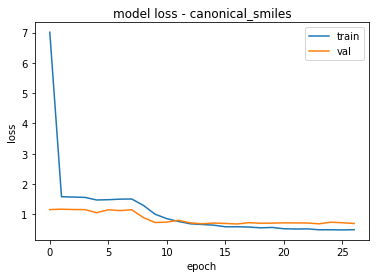

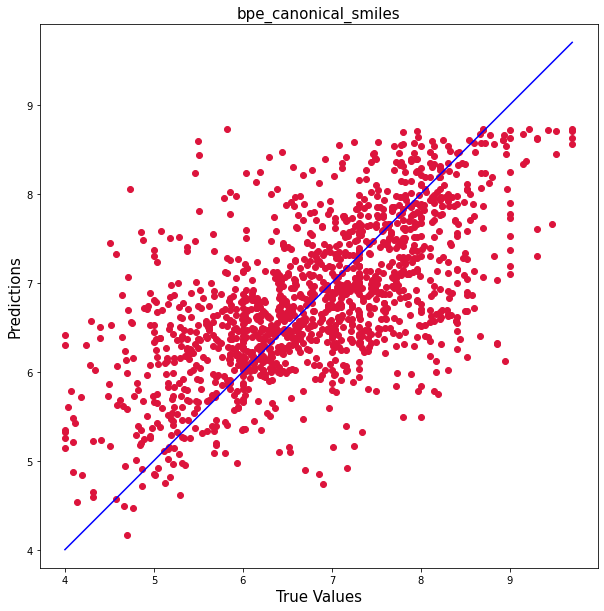

In [34]:
lengths_lst_tokenIdxs = {
    'bpe':[30] }

tokenization = 'bpe'
# m_e=3
n_patience = 10
RANDOM_STATE=42
j=0
limit =400
print('\n'+tokenization)
df = pd.read_csv('../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',sep=',')

ys = df['value']#[:limit]
linearNotation_names = ['canonical_smiles']#,'sln','deep_smiles','selfies','inchi']
list_tokens = createListTokenOut(df, RANDOM_STATE, limit, linearNotation_names)

chem_notation = 'canonical_smiles' 
# j je chemicky linearni zapis, limit je # radku kolik vezmeme (pro vyzkouseni beru jen 20)
list_token = list_tokens[j]#[:limit]
max_length=lengths_lst_tokenIdxs[tokenization][j]
X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)

best_params = {'layers': 2, 'rate1': 0.11695302548420733, 'rate2': 0.06712870390571762, 'rate3': 0.14546594628839932, 'units1': 45, 'units2': 120, 'units3': 30, 'units_embedding': 105}
m = builtModelParams(best_params,max_length,list_token,j,t_w)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
# train model
result = m.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, verbose=1, callbacks=[es])
# model prediction
y_pred = m.predict(X_test)

showPlot(result,chem_notation)

plotPredictReal(y_pred, y_test,tokenization,chem_notation)


bpe


(array([ 43.,  25.,  26.,  43.,  32., 128., 134., 176., 151., 150., 251.,
        239., 253., 250., 257., 289., 227., 293., 264., 249., 253., 170.,
        129.,  85.,  69.,  54.,  25.,  19.,   3.,   8.]),
 array([4.   , 4.194, 4.388, 4.582, 4.776, 4.97 , 5.164, 5.358, 5.552,
        5.746, 5.94 , 6.134, 6.328, 6.522, 6.716, 6.91 , 7.104, 7.298,
        7.492, 7.686, 7.88 , 8.074, 8.268, 8.462, 8.656, 8.85 , 9.044,
        9.238, 9.432, 9.626, 9.82 ]),
 <BarContainer object of 30 artists>)

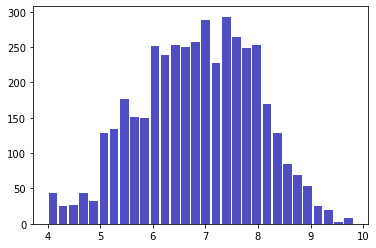

In [36]:
lengths_lst_tokenIdxs = {
    'bpe':[30] }

tokenization = 'bpe'
# m_e=3
n_patience = 10
RANDOM_STATE=42
j=0
limit =400
print('\n'+tokenization)
df = pd.read_csv('../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',sep=',')

ys = df['value']#[:limit]
linearNotation_names = ['canonical_smiles']#,'sln','deep_smiles','selfies','inchi']
list_tokens = createListTokenOut(df, RANDOM_STATE, limit, linearNotation_names)

chem_notation = 'canonical_smiles' 
# j je chemicky linearni zapis, limit je # radku kolik vezmeme (pro vyzkouseni beru jen 20)
list_token = list_tokens[j]#[:limit]
max_length=lengths_lst_tokenIdxs[tokenization][j]
X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)


plt.hist(x=y_train, bins='auto', color='#0504aa', alpha=0.7,rwidth=0.85)

# SNL


bpe
Epoch 1/4000
135/135 [==============================] - 39s 256ms/step - loss: 4.2645 - mse: 4.2645 - val_loss: 1.1578 - val_mse: 1.1578
Epoch 2/4000
135/135 [==============================] - 34s 250ms/step - loss: 1.5723 - mse: 1.5723 - val_loss: 1.1547 - val_mse: 1.1547
Epoch 3/4000
135/135 [==============================] - 34s 254ms/step - loss: 1.5827 - mse: 1.5827 - val_loss: 1.1581 - val_mse: 1.1581
Epoch 4/4000
135/135 [==============================] - 35s 256ms/step - loss: 1.5312 - mse: 1.5312 - val_loss: 1.1633 - val_mse: 1.1633
Epoch 5/4000
135/135 [==============================] - 34s 253ms/step - loss: 1.5134 - mse: 1.5134 - val_loss: 1.1501 - val_mse: 1.1501
Epoch 6/4000
135/135 [==============================] - 35s 256ms/step - loss: 1.4749 - mse: 1.4749 - val_loss: 1.1223 - val_mse: 1.1223
Epoch 7/4000
135/135 [==============================] - 34s 254ms/step - loss: 1.4330 - mse: 1.4330 - val_loss: 1.0840 - val_mse: 1.0840
Epoch 8/4000
135/135 [==============

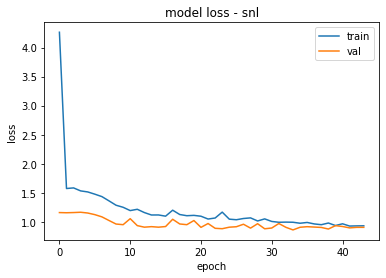

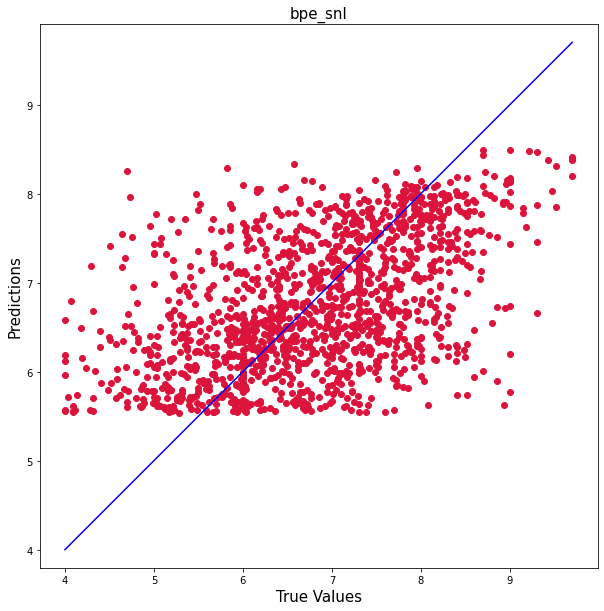

In [29]:
lengths_lst_tokenIdxs = {
    'bpe':[65],
     }

tokenization = 'bpe'
# m_e=3
n_patience = 10
RANDOM_STATE=42
j=0
limit =400
print('\n'+tokenization)
df = pd.read_csv('../data/VEGF2_ChEMBL28_tokenizationBPE_oneHotEncoding_listTokensIds_cutListTokensIds.csv',sep=',')

ys = df['value']#[:limit]
linearNotation_names = ['sln']#,'sln','deep_smiles','selfies','inchi']
list_tokens = createListTokenOut(df, RANDOM_STATE, limit, linearNotation_names)

chem_notation = 'snl' 
# j je chemicky linearni zapis, limit je # radku kolik vezmeme (pro vyzkouseni beru jen 20)
list_token = list_tokens[j]#[:limit]
max_length=lengths_lst_tokenIdxs[tokenization][j]
X_train,y_train,X_val,y_val,X_test,y_test,t_w = splitData(j, list_token, ys, RANDOM_STATE)

best_params = {'layers': 3, 'rate1': 0.13347645342762127, 'rate2': 0.011560160523319984, 'rate3': 0.34927683781734387, 'units1': 75, 'units2': 110, 'units3': 105, 'units_embedding': 20}
m = builtModelParams(best_params,max_length,list_token,j,t_w)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
# train model
result = m.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4000, verbose=1, callbacks=[es])
# model prediction
y_pred = m.predict(X_test)

showPlot(result,chem_notation)

plotPredictReal(y_pred, y_test,tokenization,chem_notation)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f98e63973a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f98e6397a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f98e638cf10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f98e629b7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f98e629b760>],
 'means': []}

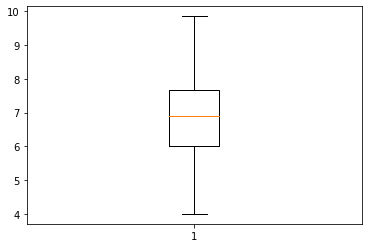

In [32]:
plt.boxplot(df['value'])

(array([ 43.,  25.,  26.,  43.,  32., 128., 134., 176., 151., 150., 251.,
        239., 253., 250., 257., 289., 227., 293., 264., 249., 253., 170.,
        129.,  85.,  69.,  54.,  25.,  19.,   3.,   8.]),
 array([4.   , 4.194, 4.388, 4.582, 4.776, 4.97 , 5.164, 5.358, 5.552,
        5.746, 5.94 , 6.134, 6.328, 6.522, 6.716, 6.91 , 7.104, 7.298,
        7.492, 7.686, 7.88 , 8.074, 8.268, 8.462, 8.656, 8.85 , 9.044,
        9.238, 9.432, 9.626, 9.82 ]),
 <BarContainer object of 30 artists>)

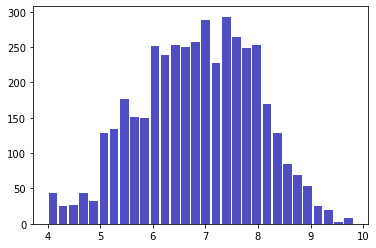

In [35]:
plt.hist(x=y_train, bins='auto', color='#0504aa', alpha=0.7,rwidth=0.85)